In [2]:
import axelrod as axl

from axelrod.random_ import random_choice

C, D = axl.Action.C, axl.Action.D

import time

In [5]:
import pandas as pd

from keras.models import Sequential, load_model

In [6]:
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    TimeDistributed,
)

In [7]:
import numpy as np
import glob
import matplotlib.pyplot as plt

In [8]:
def read_validation_dataframes(files_location):
    filenames = glob.glob(files_location)
    dfs = []
    for file in filenames:
        df = pd.read_csv(file, index_col=0)
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    return df

**LSTM model sequence to sequence top twenty**

In [9]:
files_location = "hawk_output/output_unknown_lstm_top_twenty/validation_measures_run_*.csv"
df = read_validation_dataframes(files_location)

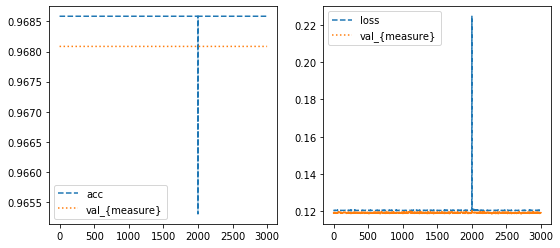

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))

for i, measure in enumerate(['acc', 'loss']):
    ax[i].plot(df[measure], '--', label=measure);
    ax[i].plot(df[f'val_{measure}'], ':', label='val_{measure}');
    ax[i].legend();

In [11]:
float(model.predict(reshape_history_lstm_model([1, 0, 0]))[0][-1])

NameError: name 'model' is not defined

**The player**

In [12]:
class LSTMPlayer(axl.Player):
    name = "The LSTM homie"
    classifier = {
        "memory_depth": float("inf"),
        "stochastic": True,
        "inspects_source": False,
        "manipulates_source": False,
        "manipulates_state": False,
    }

    def __init__(self, model, reshape_history_funct, opening_probability=0.70, input_length=False):
        self.model = model
        self.opening_probability = opening_probability
        self.reshape_history_function = reshape_history_funct
        if input_length:
            self.input_length = input_length
        super().__init__()
#         self.classifier["memory_depth"] = input_length
        if opening_probability in [0, 1]:
            self.classifier["stochastic"] = False
#         print(self.classifier)

    def strategy(self, opponent):
        if len(self.history) == 0:
            return random_choice(self.opening_probability)

        history = [action.value for action in opponent.history]
        
#         start = time.time()
        prediction = self.model.predict(self.reshape_history_function(history))
#         print(f'action time:{time.time() - start}')

        return axl.Action(round(prediction.max()))

    def __repr__(self):
        return self.name

In [13]:
def reshape_history_lstm_model(history):
    return np.array(history).reshape(1, len(history), 1)



The model needs to read in by recreating the model because it was trained on hawk and on gpu

In [14]:
num_hidden_cells = 100
drop_out_rate = 0.2

In [17]:
model = Sequential()

model.add(
    LSTM(num_hidden_cells, return_sequences=True, input_shape=(None, 1))
)

model.add(LSTM(num_hidden_cells))
model.add(Dropout(rate=drop_out_rate))

model.add((Dense(1, activation="sigmoid")))

In [18]:
model.load_weights("hawk_output/output_unknown_lstm_top_twenty/weights-over-time.h5")

In [52]:
len(model.layers)

4

In [54]:
type(model.layers[0]) == LSTM

True

In [55]:
type(model.layers[1]) == LSTM

True

**Stochastic version against basic strategies**

In [19]:
model.predict(reshape_history_lstm_model([0, 1, 1]))

array([[0.92850095]], dtype=float32)

In [20]:
player = LSTMPlayer(model, reshape_history_lstm_model)

In [21]:
strategies_tournament = [s() for s in axl.basic_strategies[:5]] + [player]

In [22]:
strategies_tournament

[Alternator, Anti Tit For Tat, Bully, Cooperator, Cycler DC, The LSTM homie]

In [24]:
tournament = axl.Tournament(players=strategies_tournament, turns=5, repetitions=1)

In [25]:
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


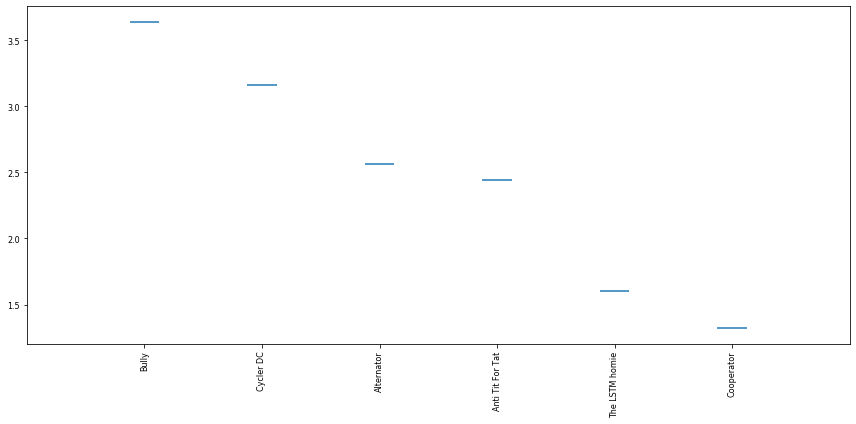

In [27]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

In [28]:
max_seed = 1
min_size = 5
max_size = 10

turns = 205
repetitions = 5

In [30]:
import random

In [31]:
axl.seed(0)
size = random.randint(min_size, max_size)
strategies = random.sample(axl.strategies, size)

In [32]:
players = [s() for s in strategies] + [player]

In [33]:
tournament = axl.Tournament(players=players, turns=5, repetitions=1)

In [35]:
results = tournament.play()

Analysing: 100%|██████████| 25/25 [00:00<00:00, 119.31it/s]


In [36]:
strategies

[axelrod.strategies.zero_determinant.ZDExtort2v2,
 axelrod.strategies.retaliate.LimitedRetaliate3,
 axelrod.strategies.apavlov.APavlov2006,
 axelrod.strategies.forgiver.ForgivingTitForTat,
 axelrod.strategies.gambler.PSOGambler2_2_2,
 axelrod.strategies.prober.Prober,
 axelrod.strategies.punisher.LevelPunisher,
 axelrod.strategies.zero_determinant.ZDSet2]

**Non stochastic version**

In [36]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=0)

In [37]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]

In [38]:
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)

In [39]:
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


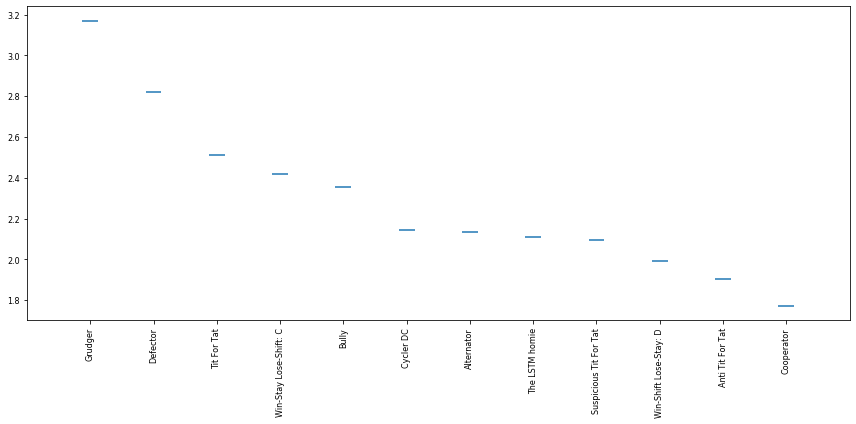

In [40]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

In [41]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=1)

In [42]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


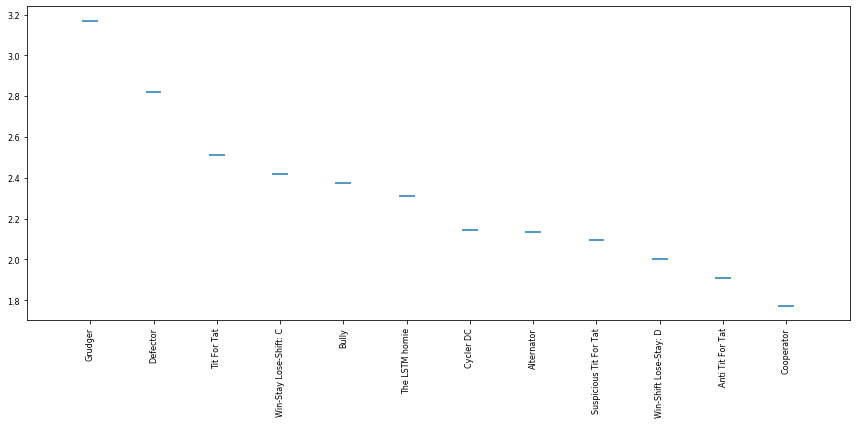

In [43]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

**LSTM model sequence to sequence all**

In [44]:
files_location = "hawk_output/output_lstm_unknown_lenght/validation_measures_run_*.csv"
df = read_validation_dataframes(files_location)

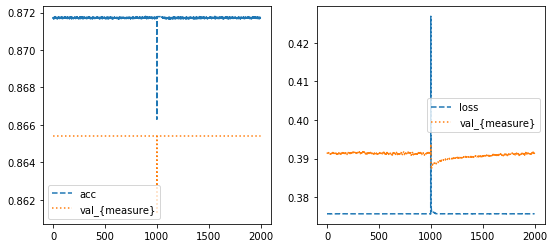

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))

for i, measure in enumerate(['acc', 'loss']):
    ax[i].plot(df[measure], '--', label=measure);
    ax[i].plot(df[f'val_{measure}'], ':', label='val_{measure}');
    ax[i].legend();

In [40]:
model = Sequential()

model.add(
    LSTM(num_hidden_cells, return_sequences=True, input_shape=(None, 1))
)

model.add(LSTM(num_hidden_cells))
model.add(Dropout(rate=drop_out_rate))

model.add((Dense(1, activation="sigmoid")))

In [41]:
model.load_weights("hawk_output/output_lstm_unknown_model/weights-over-time.h5")

**Stochastic version**

In [48]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


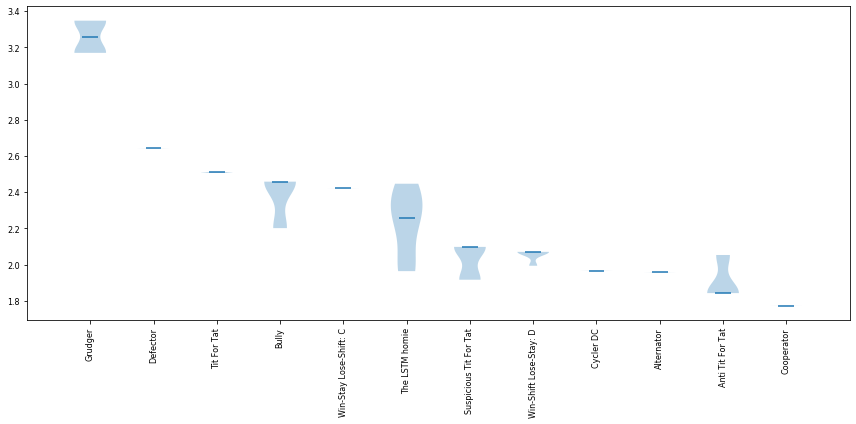

In [49]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

**non stochastic**

In [56]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=1)

In [57]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


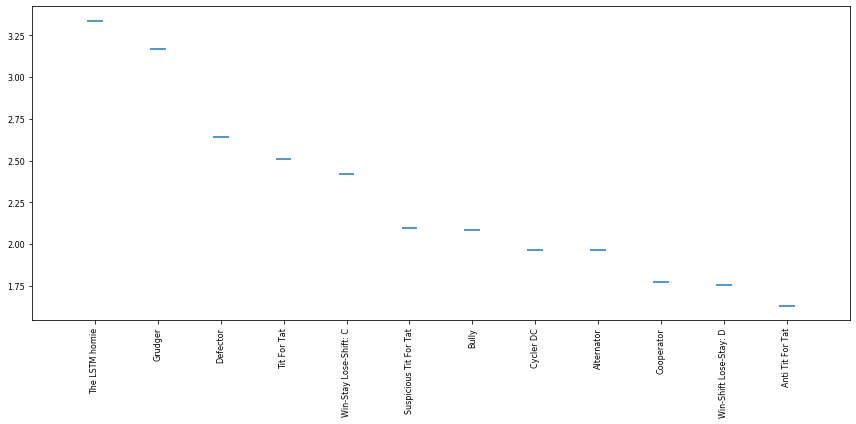

In [58]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

In [59]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=0)

In [60]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


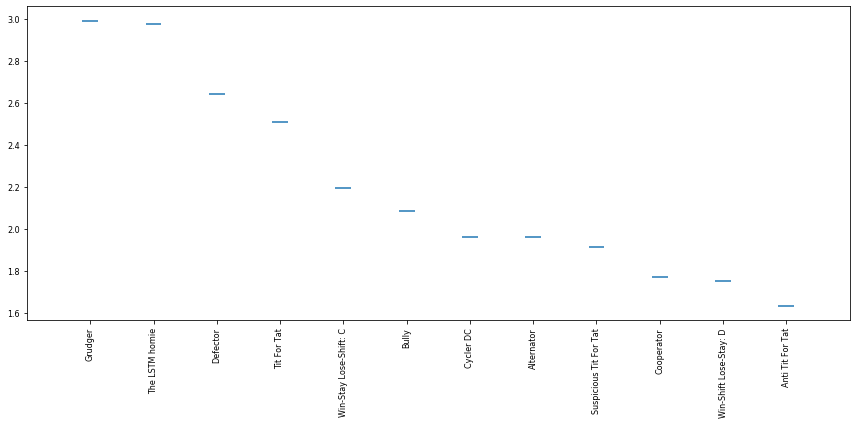

In [61]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

**LSTM model sequence to sequence basic**

In [38]:
model = load_model('basic/output_lstm/model-over-time.h5')

In [39]:
player = LSTMPlayer(model, reshape_history_lstm_model)

In [40]:
strategies_tournament = [s() for s in strategies] + [player]

In [41]:
# strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


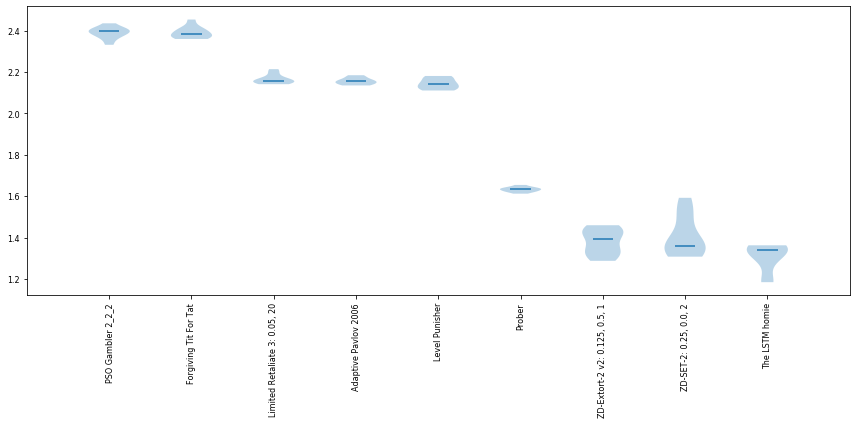

In [42]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

**Non stochastic**

In [12]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=1)

In [13]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


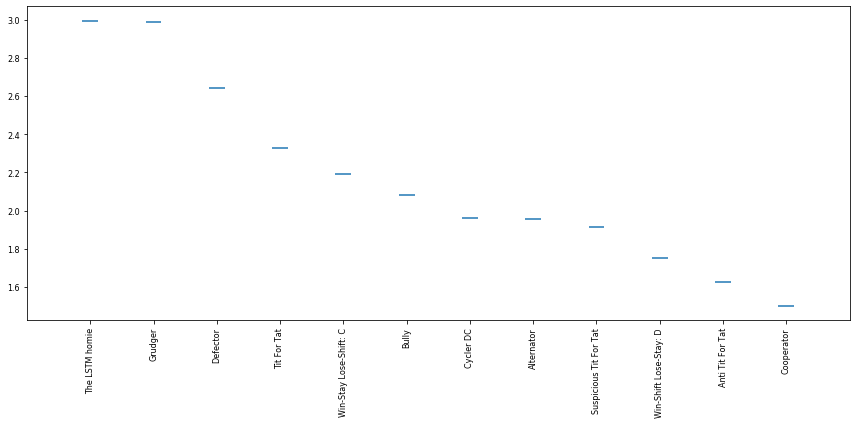

In [14]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

In [ ]:
player = LSTMPlayer(model, reshape_history_lstm_model, opening_probability=0)

In [15]:
strategies_tournament = [s() for s in axl.basic_strategies] + [player]
tournament = axl.Tournament(players=strategies_tournament, turns=205, repetitions=10)
results = tournament.play(progress_bar=False)

//anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


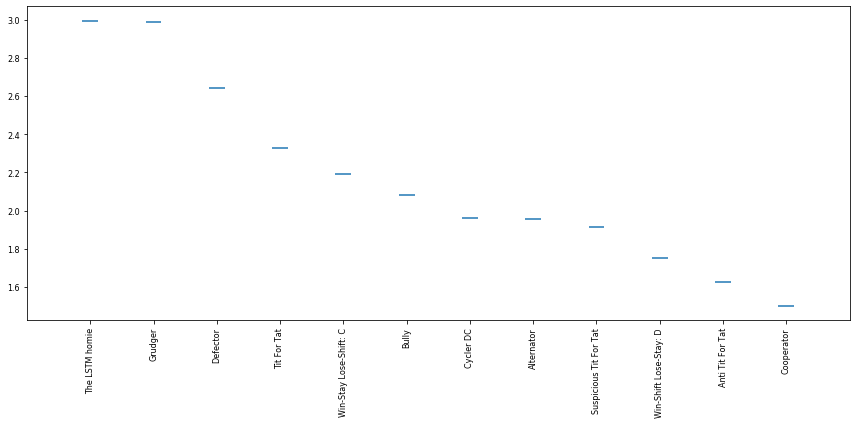

In [16]:
plot = axl.Plot(results)
p = plot.boxplot()
p.show()